# **Preference to run code in Colab**

---



In [ ]:
import pandas as pd
import numpy as np
import re
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras import layers
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Drive mount [Optional]

---



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Take Dynamic path

---



In [ ]:
dataset_path = str(input('Enter Dataset Path:\n'))
df = pd.read_csv(dataset_path)

In [ ]:
glove_path = str(input('Enter Glove Path:\n'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Analysis

---



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
label_counts = df['sentiment'].value_counts()
label_counts

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Text Pre-processing

In [ ]:
df['sentiment'] = df['sentiment'].map({'positive':1 , 'negative': 0})

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def punctuation_remove(text):
    text = re.sub(r"@\S+|https?:\S+|http?:\S|<br>|<br />", ' ', str(text).lower()).strip()
    punctuation_pattern = "[" + re.escape(string.punctuation) + "]"
    text = re.sub(punctuation_pattern, "", text)
    return text
def remove_stopwords(text):
  words = word_tokenize(text)
  stopword = stopwords.words('english')
  words_without_stopwords = []
  for word in words:
    if word not in stopword:
      words_without_stopwords.append(word)
  processed_text = " ".join(words_without_stopwords)
  return processed_text

In [ ]:
df['review'] = df['review'].apply(punctuation_remove)
df['review'] = df['review'].apply(remove_stopwords)

In [ ]:
from collections import Counter
all_words = []
for review in df['review']:
    words_in_review = word_tokenize(review.lower())
    all_words.extend(words_in_review)
word_count = Counter(all_words)
vocab_size = len(word_count)
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 167313


In [ ]:
word_count.most_common(10)

[('movie', 85224),
 ('film', 76034),
 ('one', 51479),
 ('like', 39063),
 ('good', 28912),
 ('even', 24582),
 ('would', 24036),
 ('time', 23961),
 ('really', 23011),
 ('see', 22640)]

# Word Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
vocab_size = len(tokenizer.word_index)
maxlen = 256
data_sequences = tokenizer.texts_to_sequences(df['review'])
data = pad_sequences(data_sequences, padding='post', maxlen=maxlen)

# GloVe

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(glove_path, tokenizer.word_index, embedding_dim)

# Train-Test split

In [ ]:
from sklearn.model_selection import train_test_split
X = data
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'Train data shape {X_train.shape}')
print(f'Test data shape {X_test.shape}')
print(f'Train lebel shape {y_train.shape}')
print(f'Test lebel shape {y_test.shape}')

Train data shape (40000, 256)
Test data shape (10000, 256)
Train lebel shape (40000,)
Test lebel shape (10000,)


# Uni-LSTM [Unit=64] [Batch Size = 32] [activation='tanh']

---



In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen))

model.add(LSTM(units=64, activation='tanh', return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          16731300  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16773605 (63.99 MB)
Trainable params: 16773605 (63.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=5,
                    validation_split=0.2,
                    batch_size=32)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Training Accuracy: 0.9702
Testing Accuracy:  0.8590


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

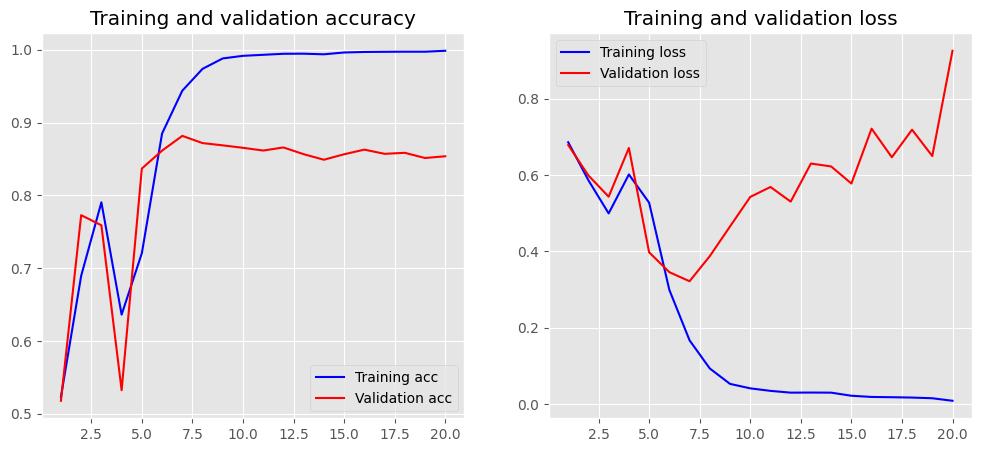

In [ ]:
plot_history(history)